In [1]:
from IPython.display import clear_output
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import re

from tqdm import tqdm
import sys
import dropbox
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl
from amftrack.util.dbx import (
    load_dbx,
    download,
    upload,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
)
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
    
)

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 200

print("import great succes!")
%reload_ext autoreload

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-02-02 15:01:30.958780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 15:01:31.516257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

import great succes!


In [2]:
analysis_folder = "/gpfs/home6/svstaalduine/Analysis/CocoTransport/"
dropbox_address = "/DATA/CocoTransport/"
excel_name = "handSpeed.xlsx"

analysis_filter = "2023*/"

In [3]:
%%time
# edgedata = glob.glob("/gpfs/home6/svstaalduine/Analysis/CocoTransport/20230906_Plate310/052/Img/*csv")
edgedata = glob.glob(analysis_folder+analysis_filter+"*/*/*.csv")
print(len(edgedata))
print(analysis_folder+analysis_filter+"*/*.csv")

20830
/gpfs/home6/svstaalduine/Analysis/CocoTransport/2023*/*/*.csv
CPU times: user 238 ms, sys: 302 ms, total: 539 ms
Wall time: 971 ms


In [ ]:
df1 = pd.read_csv(edgedata[0])
print(df1)

In [4]:
%%time

list_of_dfs = []

interested_subdirectories = ['20230906_Plate310']
# Walk through the directory and its subdirectories
i=0
for root, dirs, files in os.walk(analysis_folder):
#     if any(subdir in root for subdir in interested_subdirectories):
        for file in files:
            if file.endswith('edges_data.csv'):
                
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                jsnpath = file_path[:-14]+'video_data.json'
                 
                with open(jsnpath, 'r') as file:
                    jason = json.load(file)
                 
                df.insert(1,"mode",jason['mode'])
                df.insert(2,"video_int",jason['video_int'])
                 
                list_of_dfs.append(df)
                    

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(list_of_dfs, ignore_index=True)

print(len(combined_df))
print(combined_df.iloc[0])

8051
Unnamed: 0                  0
mode                       BF
video_int                  68
edge_name              (1, 0)
edge_length           101.982
straight_length    107.484638
speed_max            6.754127
speed_min          -10.845769
speed_mean          -0.455641
flux_avg            -8.952165
flux_min          -106.570153
flux_max             54.79373
speed_left          -3.204716
speed_right          2.599185
speed_left_std        0.57839
speed_right_std      0.289898
coverage_left         0.35297
coverage_right       0.302923
coverage_tot         0.548674
edge_xpos_1            1489.0
edge_ypos_1             812.0
edge_xpos_2               1.0
edge_ypos_2            1416.0
Name: 0, dtype: object
CPU times: user 13 s, sys: 2.05 s, total: 15 s
Wall time: 26.4 s


In [6]:
print(df.columns.tolist())

['Unnamed: 0', 'mode', 'video_int', 'edge_name', 'edge_length', 'straight_length', 'speed_max', 'speed_min', 'speed_mean', 'flux_avg', 'flux_min', 'flux_max', 'speed_left', 'speed_right', 'speed_left_std', 'speed_right_std', 'coverage_left', 'coverage_right', 'coverage_tot', 'edge_xpos_1', 'edge_ypos_1', 'edge_xpos_2', 'edge_ypos_2']


In [44]:
the_great_filtering = ['(18, 11)', '(10, 3)', '(51,23)']
filtered_df=combined_df[combined_df['edge_name'].isin(the_great_filtering)]

In [45]:
print(filtered_df['edge_name'])

34     (10, 3)
247    (10, 3)
Name: edge_name, dtype: object


In [5]:
%%time
sel_df = combined_df
# sel_df = combined_df[combined_df['speed_left']<=-0.4]
# sel_df = sel_df[sel_df['speed_right']>=0.4]
# sel_df = sel_df[sel_df['coverage_right']>=0.25]
# sel_df = sel_df[sel_df['coverage_left']>=0.25]
# sel_df = sel_df[sel_df['coverage_tot']>=0.2]
# sel_df = sel_df[sel_df['straight_length']<=200]


# sel_df = sel_df[sel_df['std_right']<=0.16]



BF_df = sel_df[sel_df['mode']=='BF']
FL_df = sel_df[sel_df['mode']=='F']

print(len(BF_df))
print(len(FL_df))

# print(BF_df[BF_df['edge_name']=='(24, 5)'])

4981
3070
CPU times: user 6.43 ms, sys: 867 µs, total: 7.29 ms
Wall time: 9.44 ms


In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(FL_df)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(combined_BF_df['speed_left'],combined_BF_df['speed_right'], alpha=combined_BF_df['coverage_tot'], color='green')
ax.scatter(combined_FL_df['speed_left'],combined_FL_df['speed_right'], alpha=combined_FL_df['coverage_tot'], color='red')
plt.show()

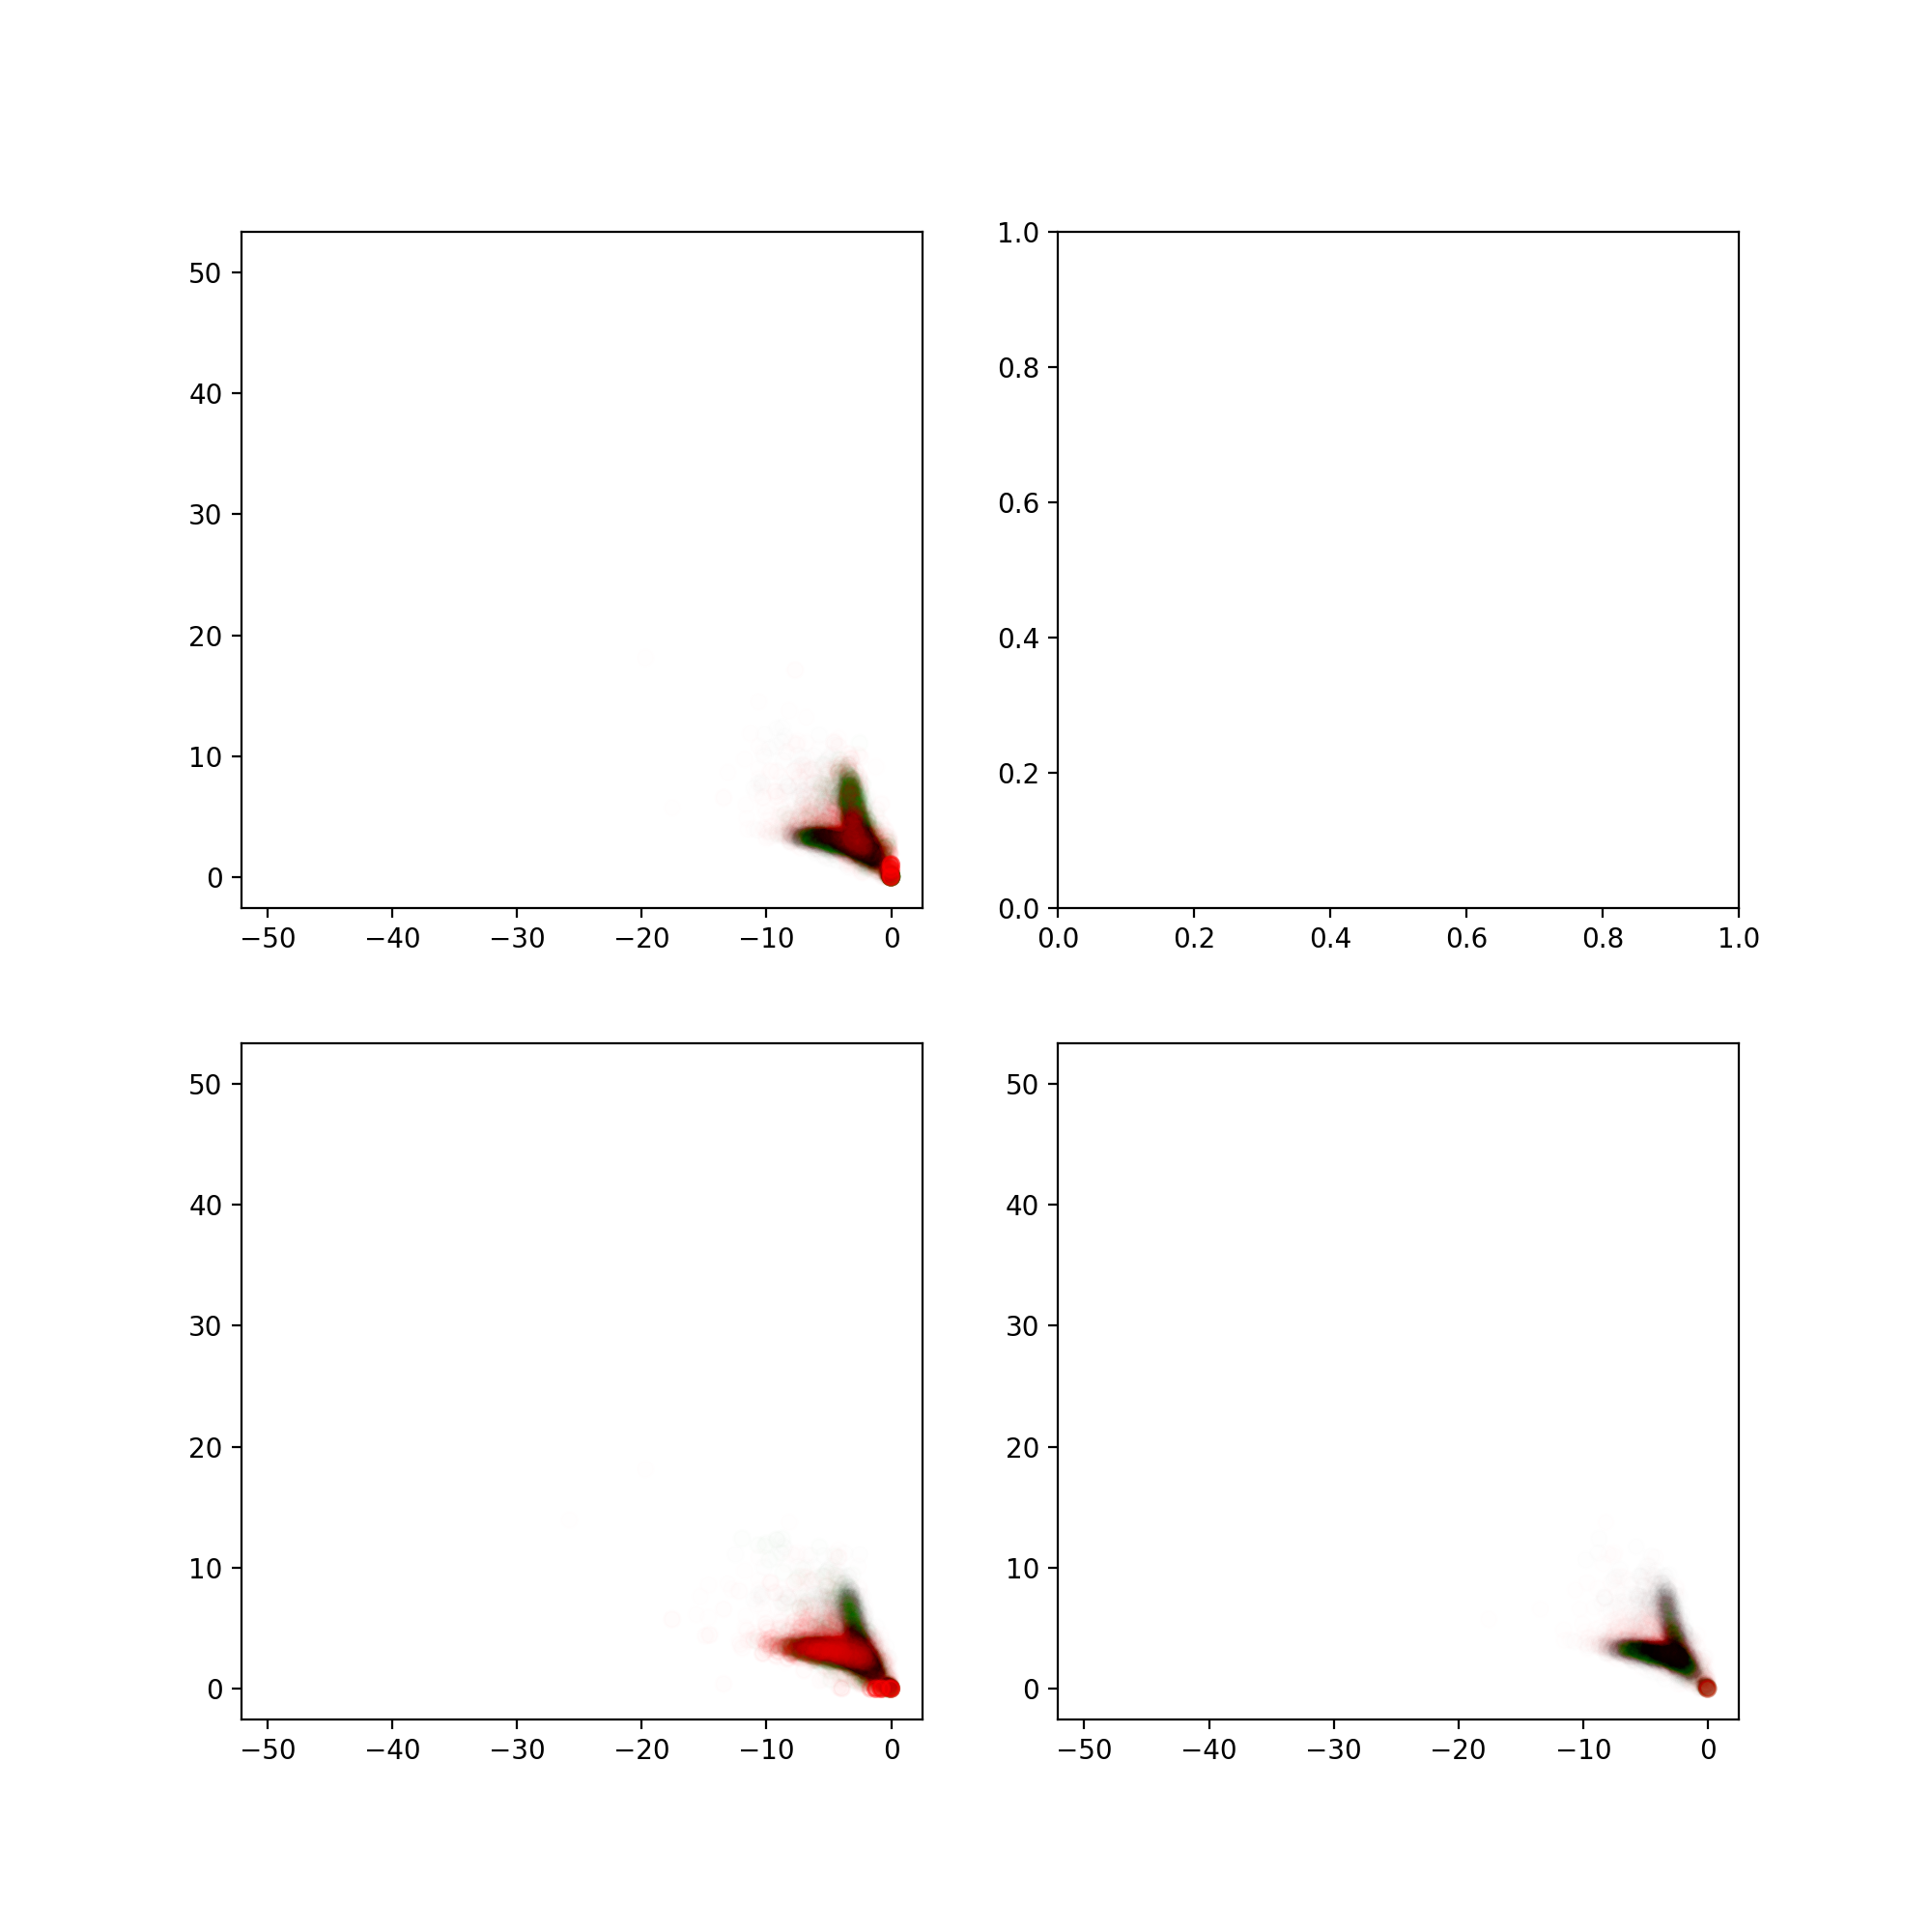

In [6]:
plt.close('all')
alpha=min(min(BF_df['speed_left_std']),min(FL_df['speed_left_std']),min(BF_df['speed_right_std']),min(FL_df['speed_right_std']))

plt.close('all')
fig, ax = plt.subplots(2,2, figsize=(10, 10))
# ax[0][0].set_xlim(-12,0)
# ax[0][0].set_ylim(0,12)
# ax[1][0].set_xlim(-12,0)
# ax[1][0].set_ylim(0,12)
# ax[1][1].set_xlim(-12,0)
# ax[1][1].set_ylim(0,12)
ax[0][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=alpha/BF_df['speed_left_std'], color='green')
ax[0][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=alpha/FL_df['speed_left_std'], color='red')
ax[1][0].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=alpha/BF_df['speed_right_std'], color='green')
ax[1][0].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=alpha/FL_df['speed_right_std'], color='red')
ax[1][1].scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=alpha/(BF_df['speed_right_std']+BF_df['speed_left_std']), color='green')
ax[1][1].scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=alpha/(FL_df['speed_right_std']+FL_df['speed_left_std']), color='red')

plt.show()

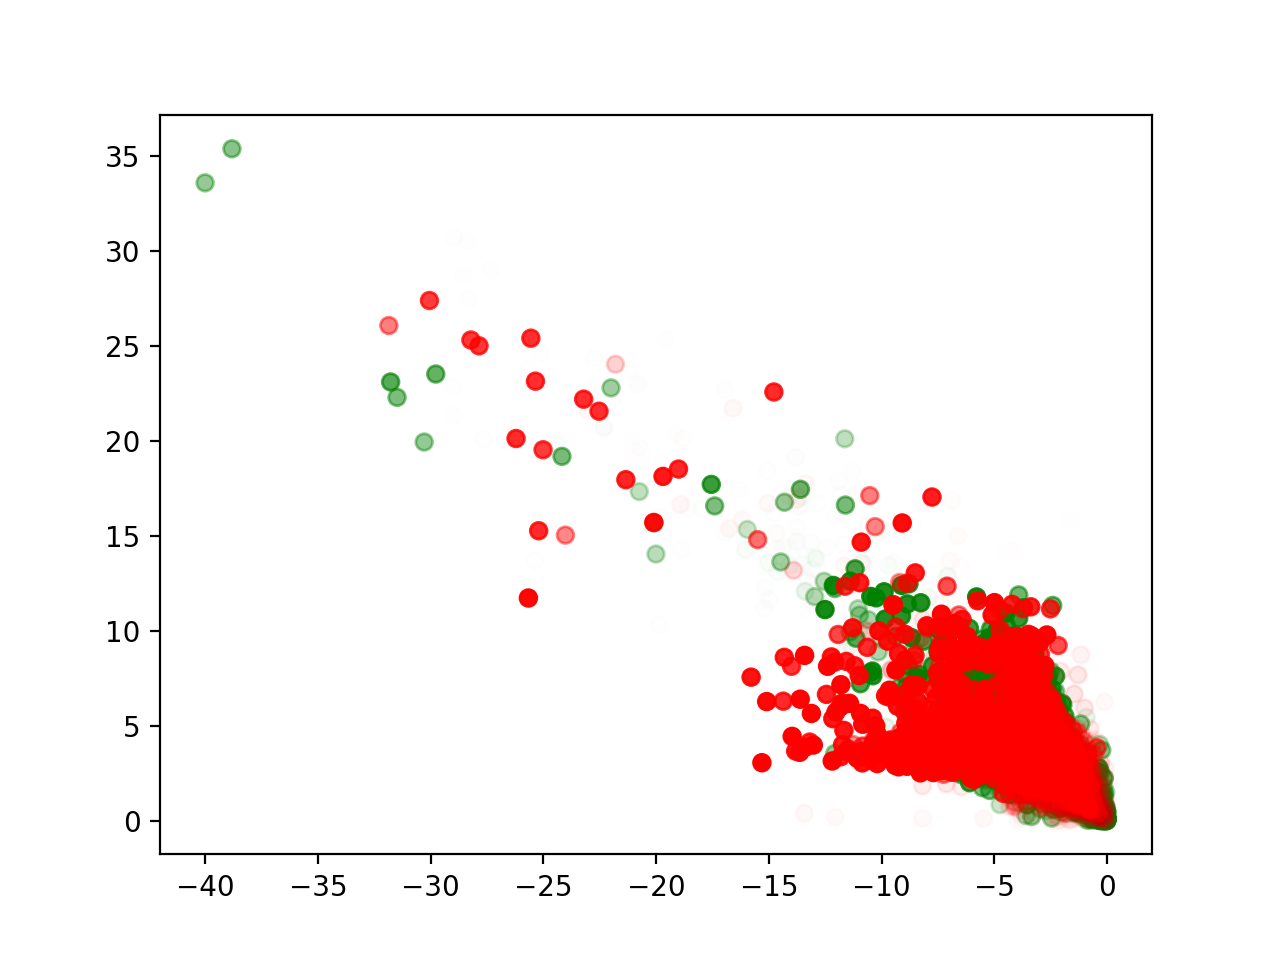

In [7]:
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=BF_df['coverage_tot'], color='green')
ax.scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=FL_df['coverage_tot'], color='red')
plt.show()

1. download the excel by hand analysis.
2. load it into a dataframe.
3. compare it with the automated simon analysis.
unfortunately it is not directly comparable anymore :(. the segmentation has changed so edges and kymographs of the old by hand analysed data do not exist anymore.

In [30]:
print(dropbox_address+excel_name)
excel_address=analysis_folder+excel_name
download(file_path=dropbox_address+excel_name, target_path=excel_address, catch_exception=False)


/DATA/CocoTransport/handSpeed.xlsx
2024-01-31 11:42:23,239-[INFO]- dropbox:390 -> Refreshing access token.
2024-01-31 11:42:23,448-[INFO]- dropbox:474 -> Request to files/download


In [7]:
excel_address=analysis_folder+excel_name
print(excel_address)

byhand = pd.read_excel(excel_address)
byhand['std speed right'].fillna(2.5,inplace=True)
byhand['std speed left'].fillna(2.5,inplace=True)


print(byhand)

/gpfs/home6/svstaalduine/Analysis/CocoTransport/handSpeed.xlsx
      edge mode  average speed left  average speed right  std speed left  \
0    18.11   BF            2.863214            -4.784693        0.387053   
1    10.30   BF            6.453744            -2.847289        0.778757   
2    51.23   BF            2.795139            -3.824769        0.329135   
3    17.90   BF            5.590312            -3.371446        1.452048   
4     9.50   BF            6.021151            -3.219436        1.039750   
5     5.20   BF            3.871855            -2.794534        0.789848   
6    42.32   BF            4.495466            -2.744148        1.433430   
7    20.60   BF            2.726457            -3.120134        0.215129   
8    24.50   BF            0.000000            -0.014692        2.500000   
9    25.60   BF            2.364460            -2.542389        0.985207   
10   37.30   BF            2.868176            -3.660367        0.966569   
11   23.20   BF          

In [9]:
BFhand=byhand[byhand['mode']=="BF"]
FLhand=byhand[byhand['mode']=="FL"]


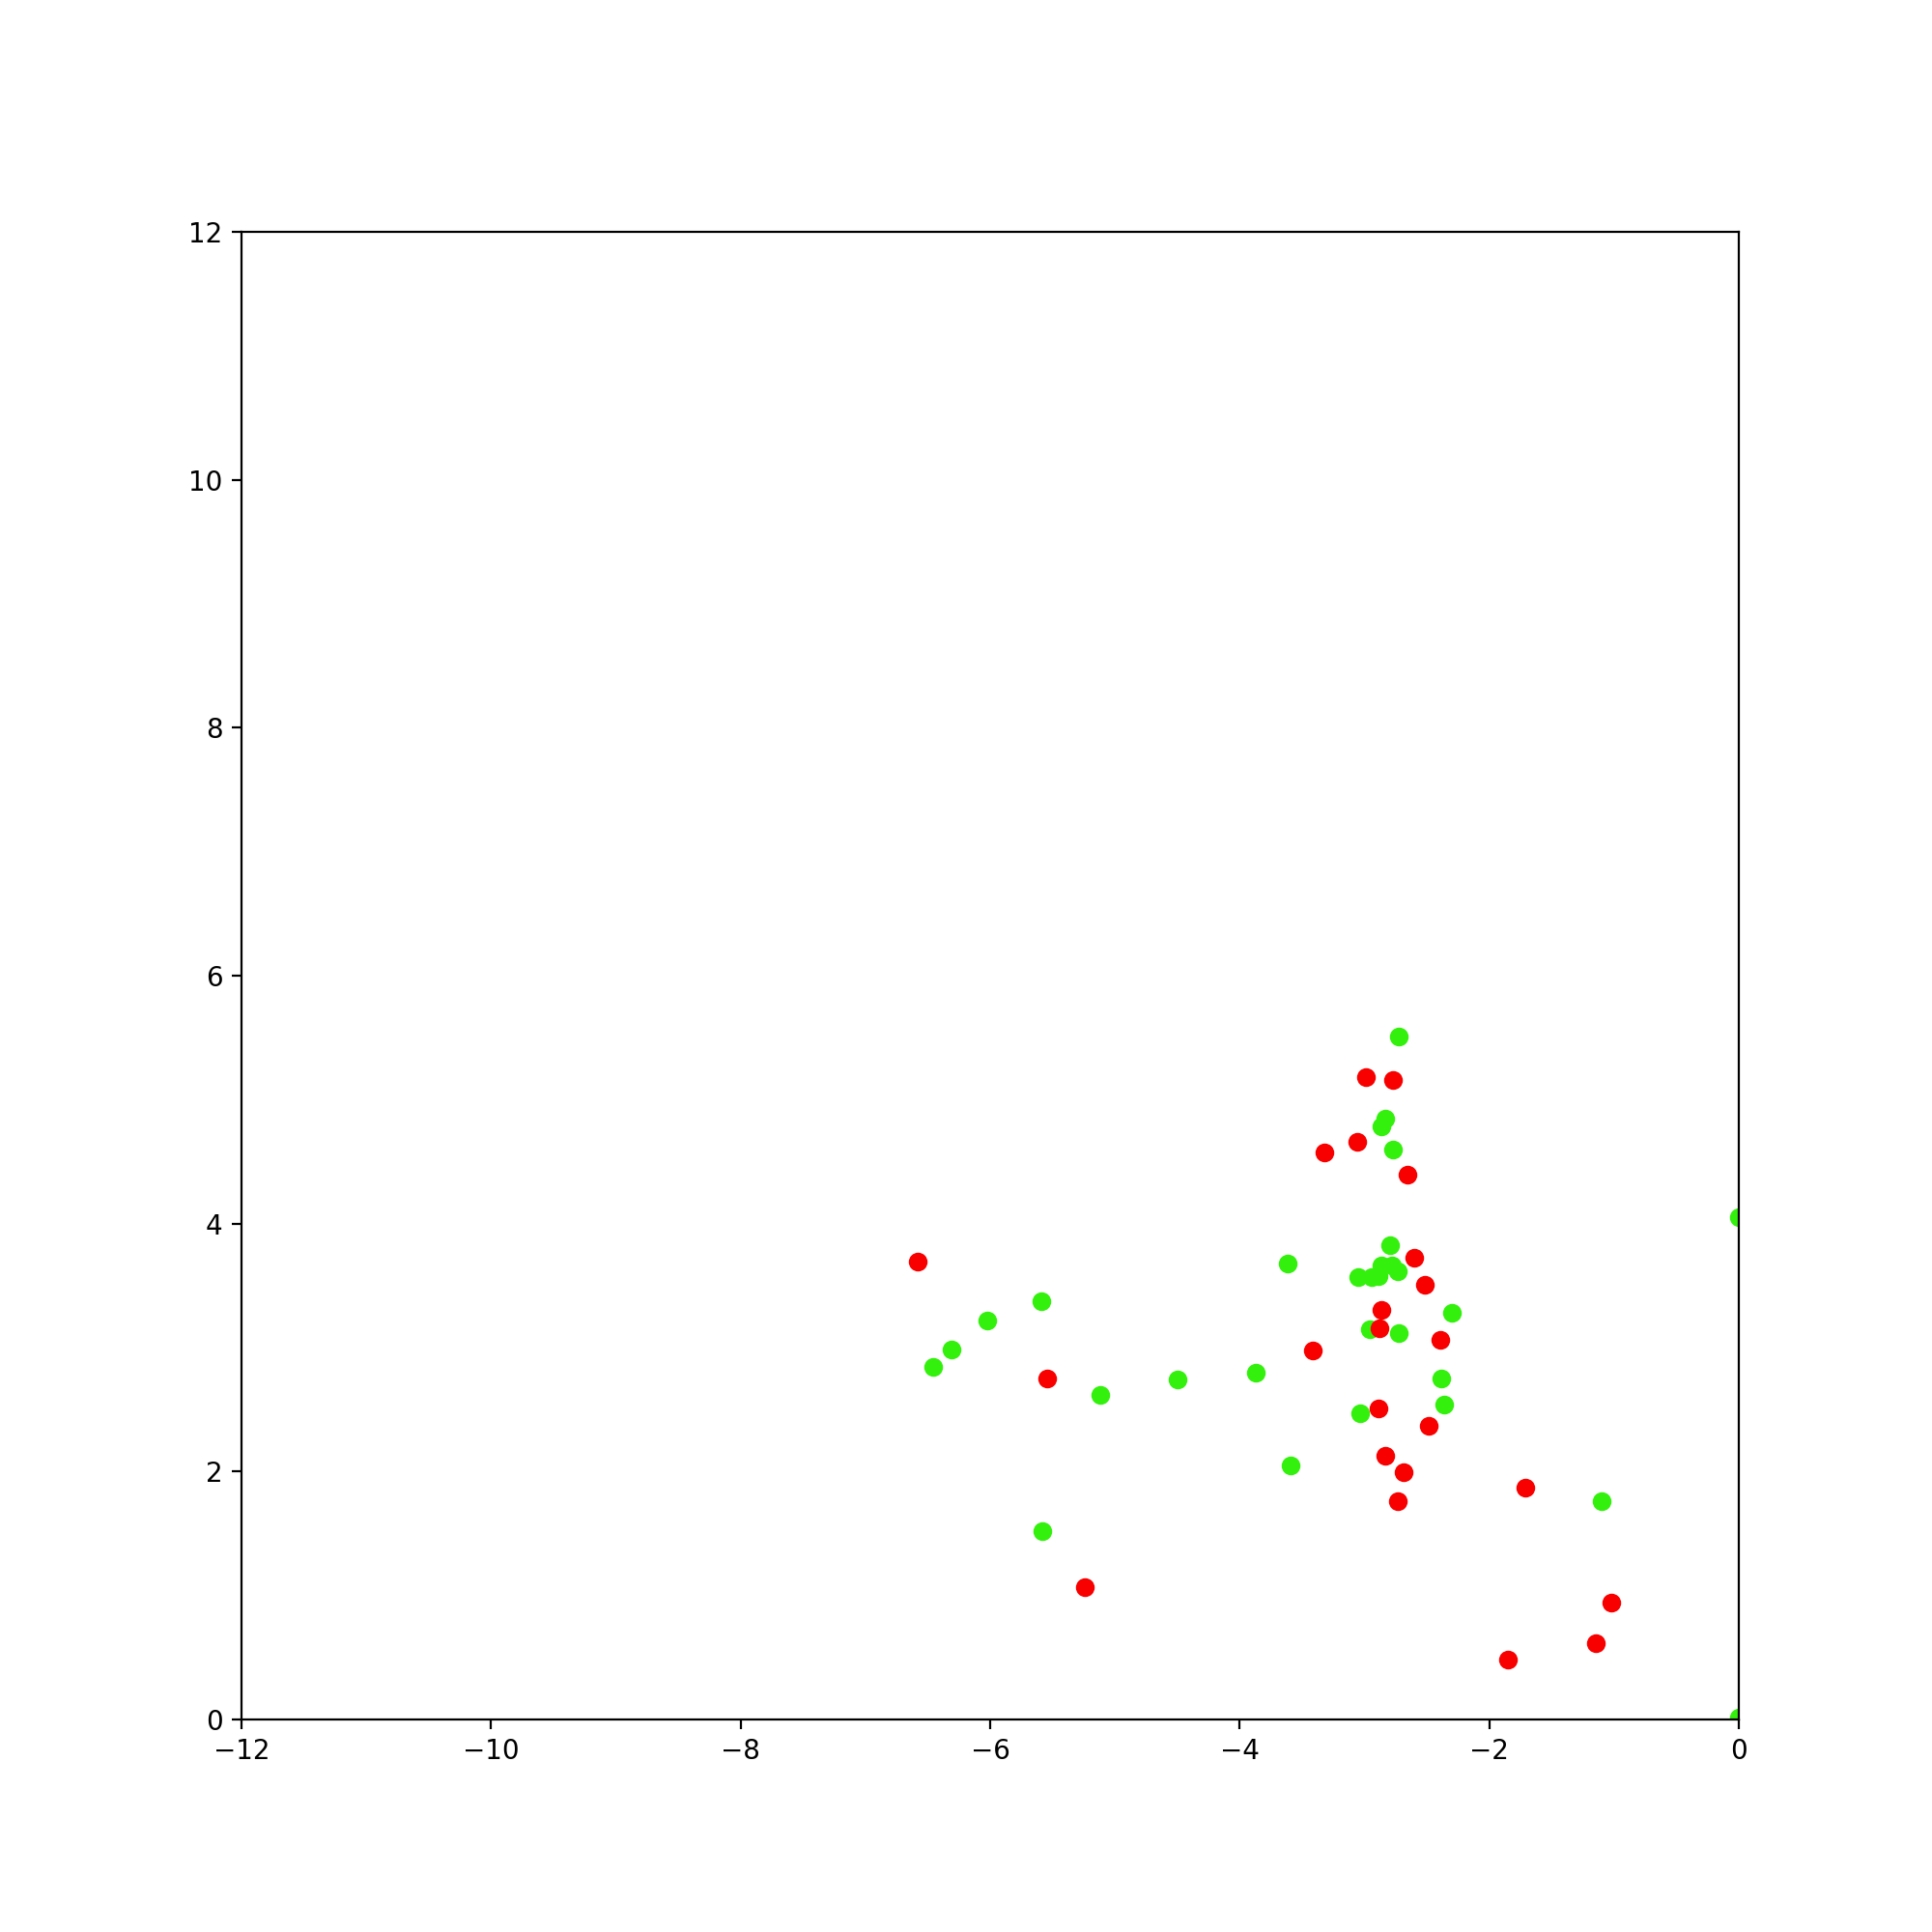

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_xlim(-12,0)
ax.set_ylim(0,12)

#due to flipping of the directions we have to multiply by -1 to compare by hand with automatic
ax.scatter(-1*BFhand['average speed left'],-1*BFhand['average speed right'], color='#33f10d')
ax.scatter(-1*FLhand['average speed left'],-1*FLhand['average speed right'], color='#f90000')
ax.scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=alpha*BF_df['coverage_tot'], color='#108604')
ax.scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=alpha*FL_df['coverage_tot'], color='#A22107')


plt.show()

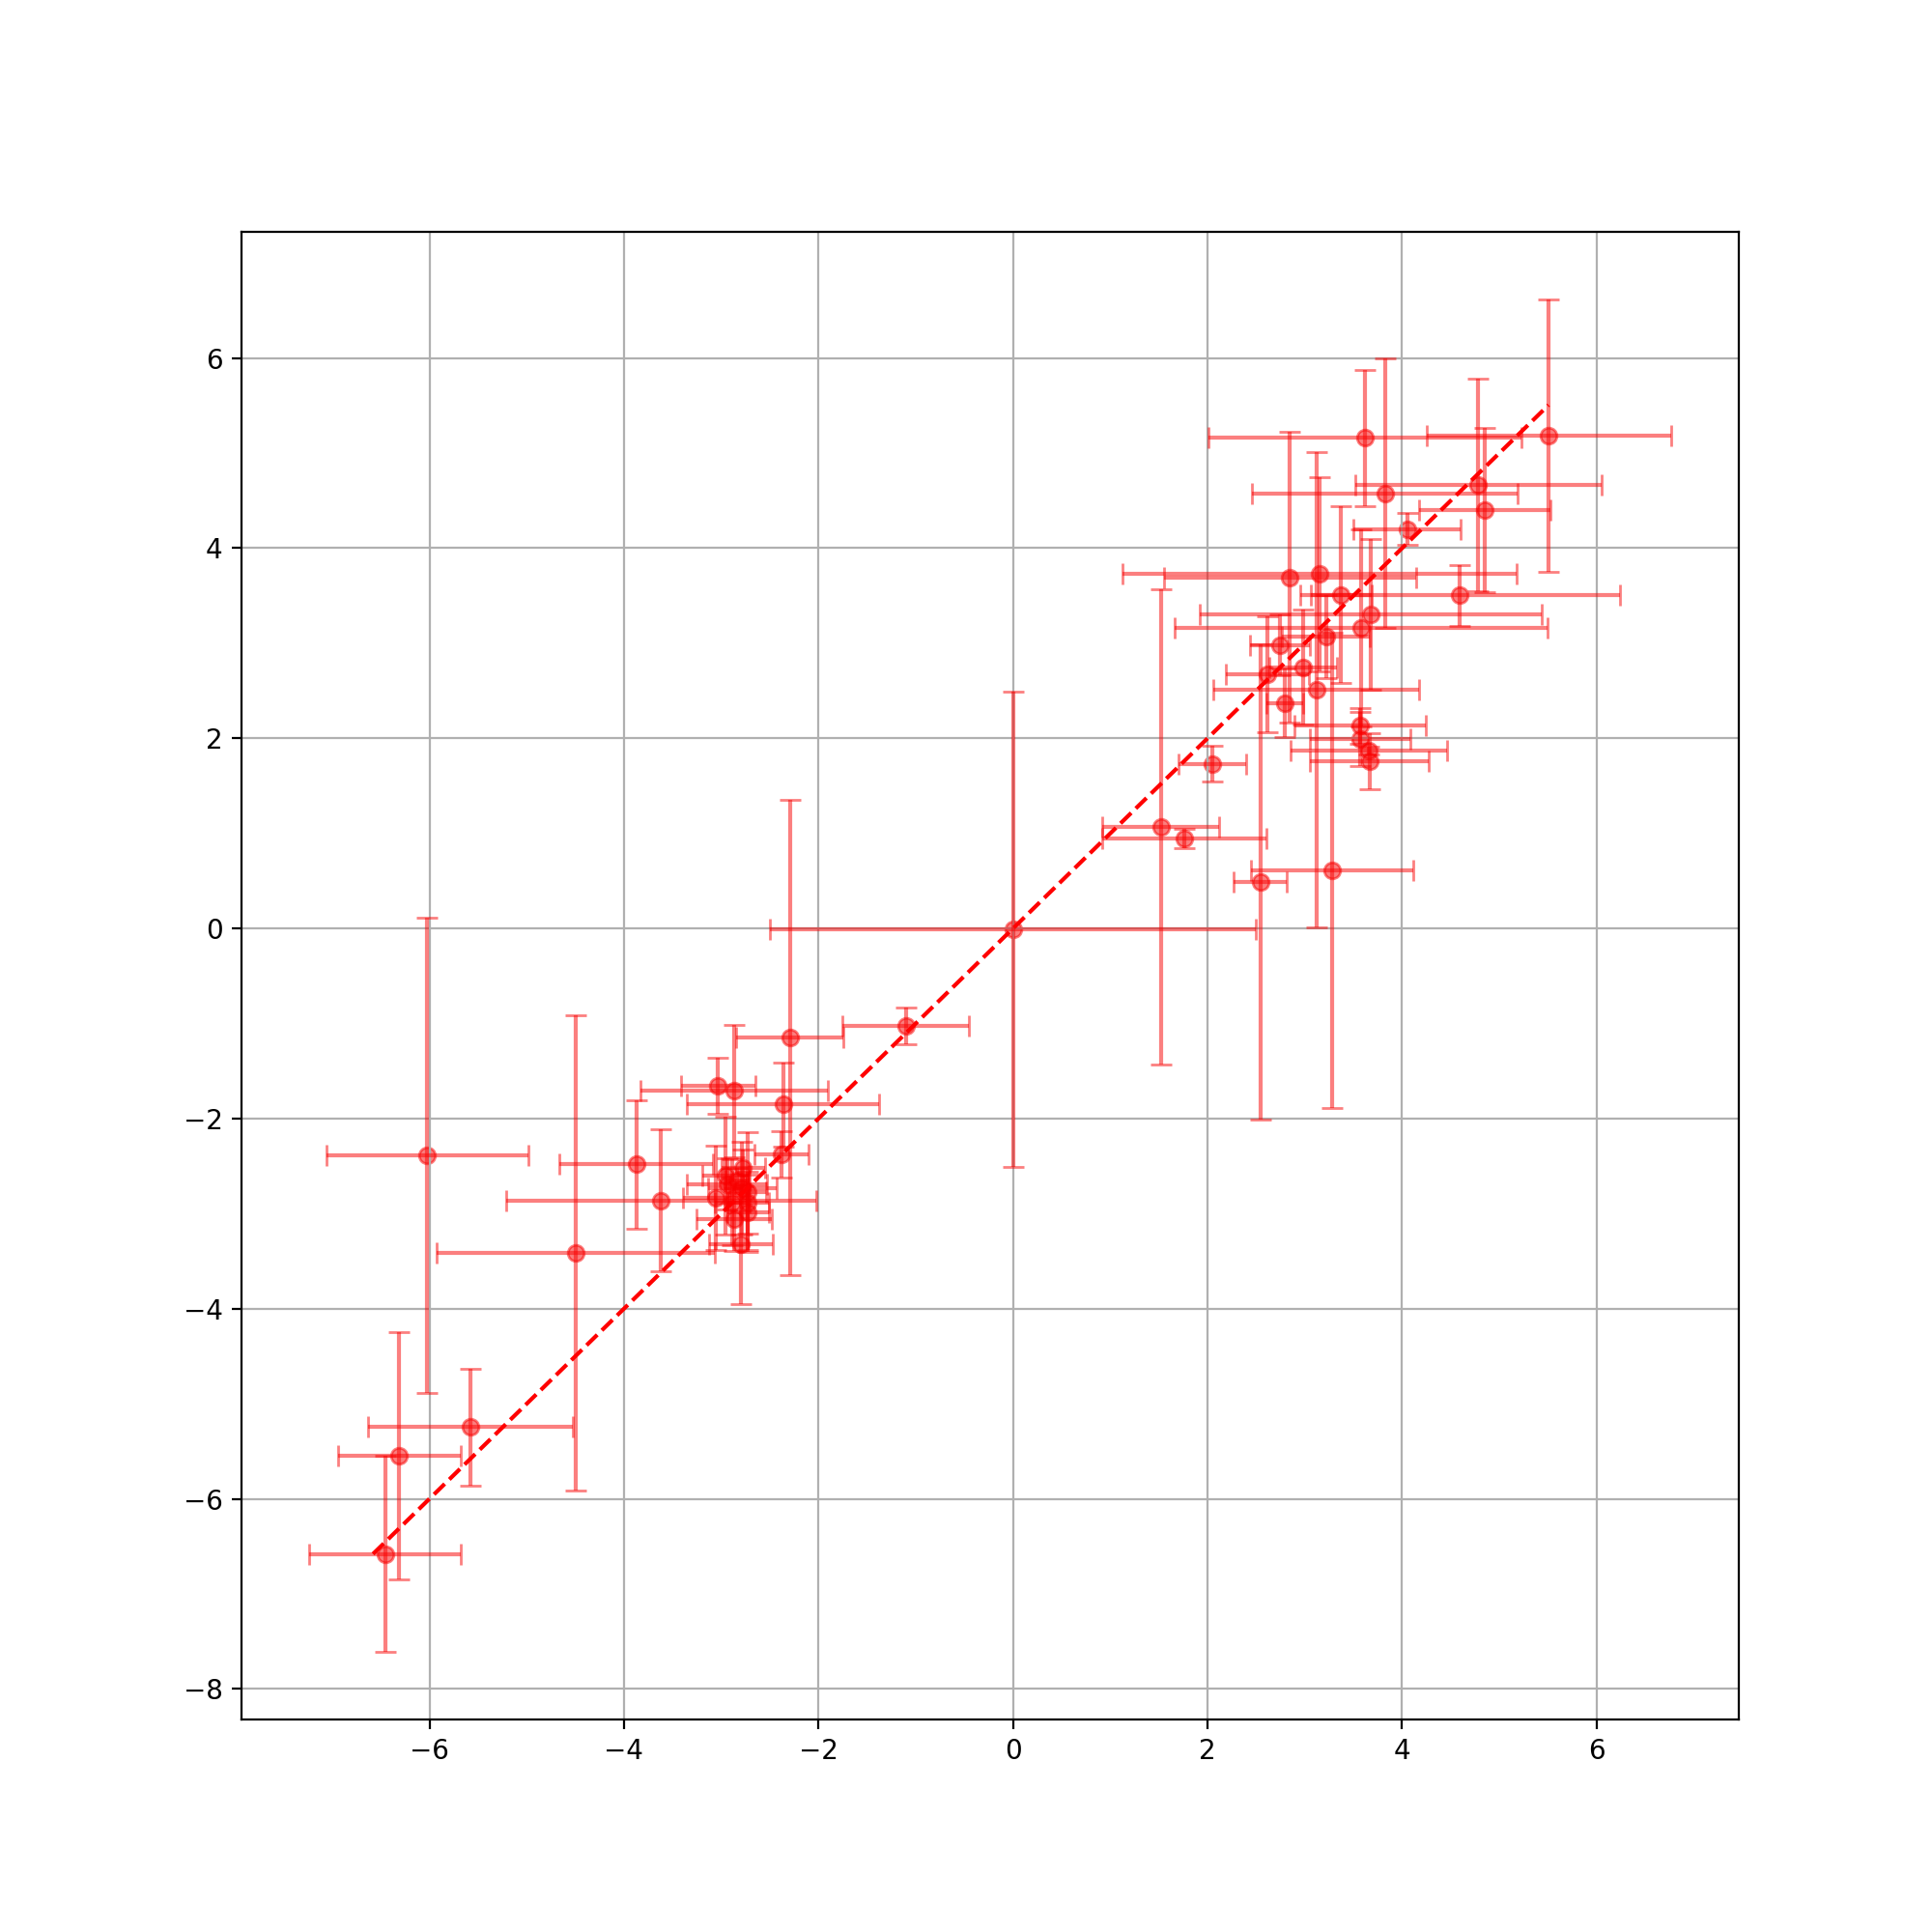

In [64]:


fig, ax = plt.subplots(1, figsize=(10, 10))
# ax.set_xlim(-12,0)
# ax.set_ylim(0,12)

#due to flipping of the directions we have to multiply by -1 to compare by hand with automatic
ax.scatter(-1*BFhand['average speed left'],-1*FLhand['average speed left'], alpha=0.5, color='#f90000')
ax.scatter(-1*BFhand['average speed right'],-1*FLhand['average speed right'], alpha=0.5, color='#f90000')
# ax.scatter(BF_df['speed_left'],BF_df['speed_right'], alpha=alpha*BF_df['coverage_tot'], color='#108604')
# ax.scatter(FL_df['speed_left'],FL_df['speed_right'], alpha=alpha*FL_df['coverage_tot'], color='#A22107')
ax.errorbar(-1*BFhand['average speed left'], -1*FLhand['average speed left'], xerr=BFhand['std speed left'], yerr=FLhand['std speed left'], alpha=0.5, fmt='none', ecolor='#f90000', capsize=4, label='Error Bars')
ax.errorbar(-1*BFhand['average speed right'], -1*FLhand['average speed right'], xerr=BFhand['std speed right'], yerr=FLhand['std speed right'], alpha=0.5, fmt='none', ecolor='#f90000', capsize=4, label='Error Bars')

min_val = min(min(-1*BFhand['average speed left']), min(-1*FLhand['average speed left']))
max_val = max(max(-1*BFhand['average speed right']), max(-1*FLhand['average speed right'],))
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')
ax.grid(True)

plt.show()

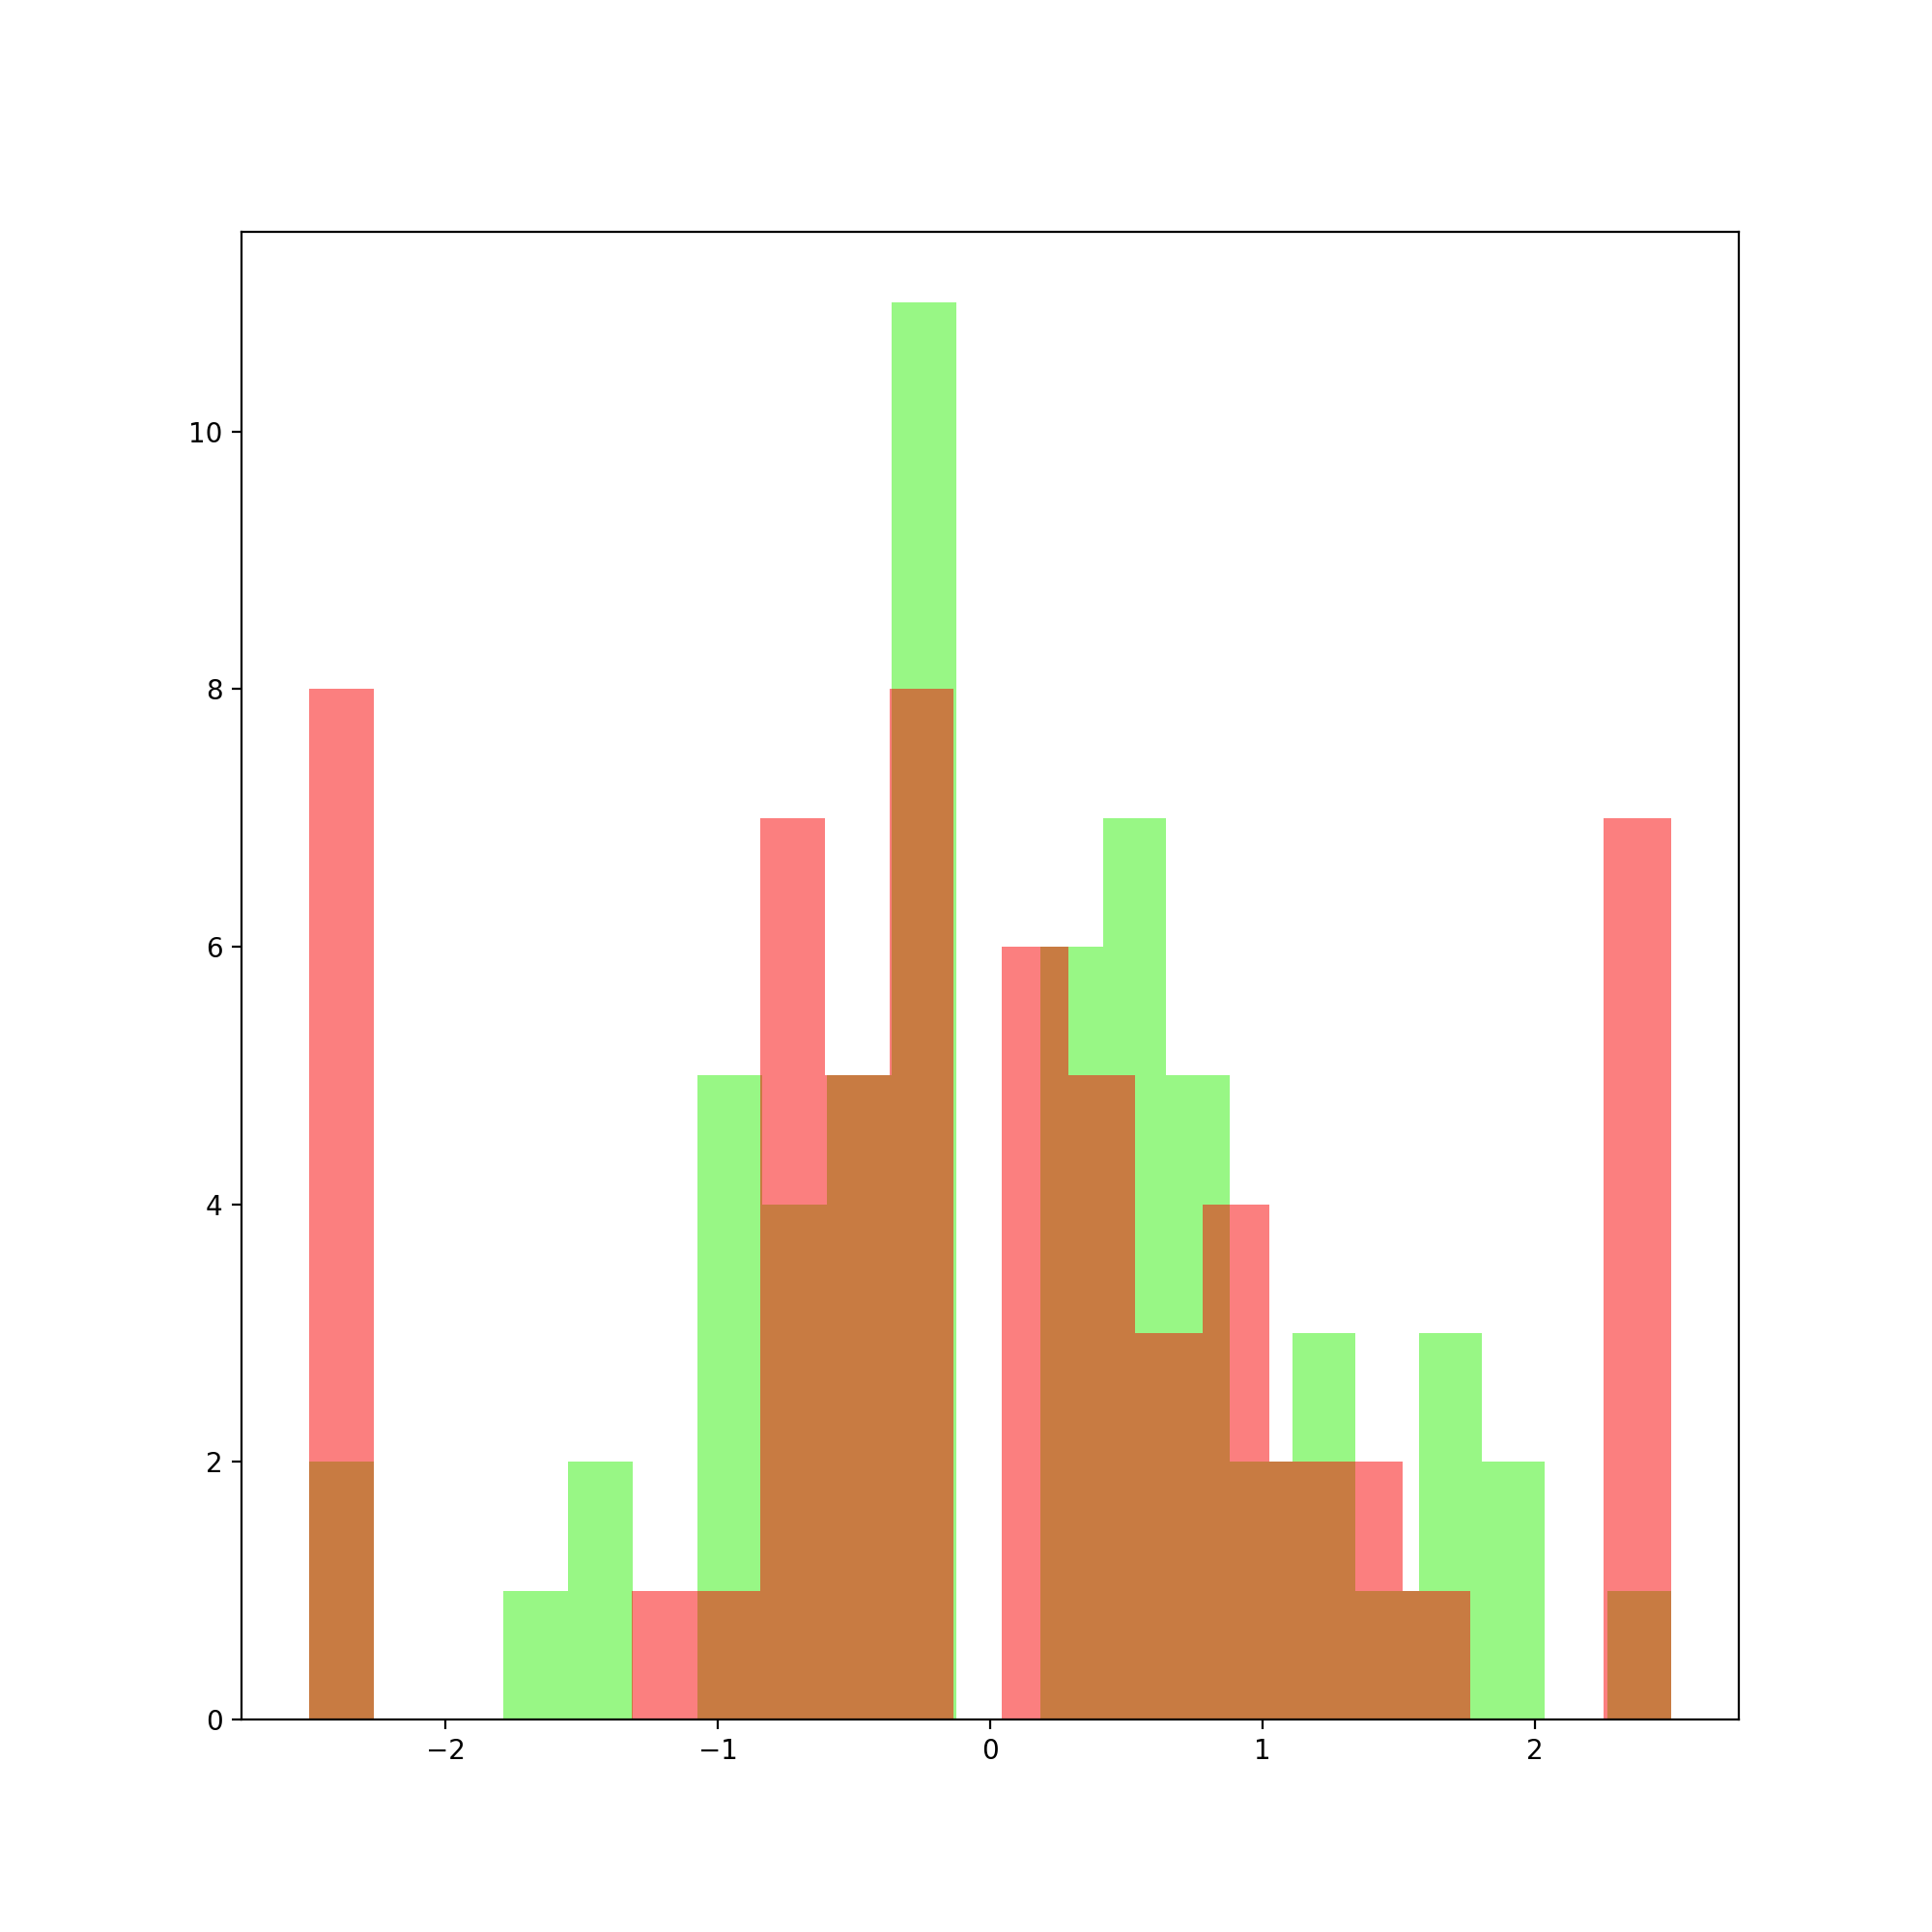

In [67]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(-1*BFhand['std speed left'], alpha=0.5, color='#33f10d')
ax.hist(BFhand['std speed right'], alpha=0.5, color='#33f10d')
ax.hist(-1*FLhand['std speed left'], alpha=0.5, color='#f90000')
ax.hist(FLhand['std speed right'], alpha=0.5, color='#f90000')


plt.show()

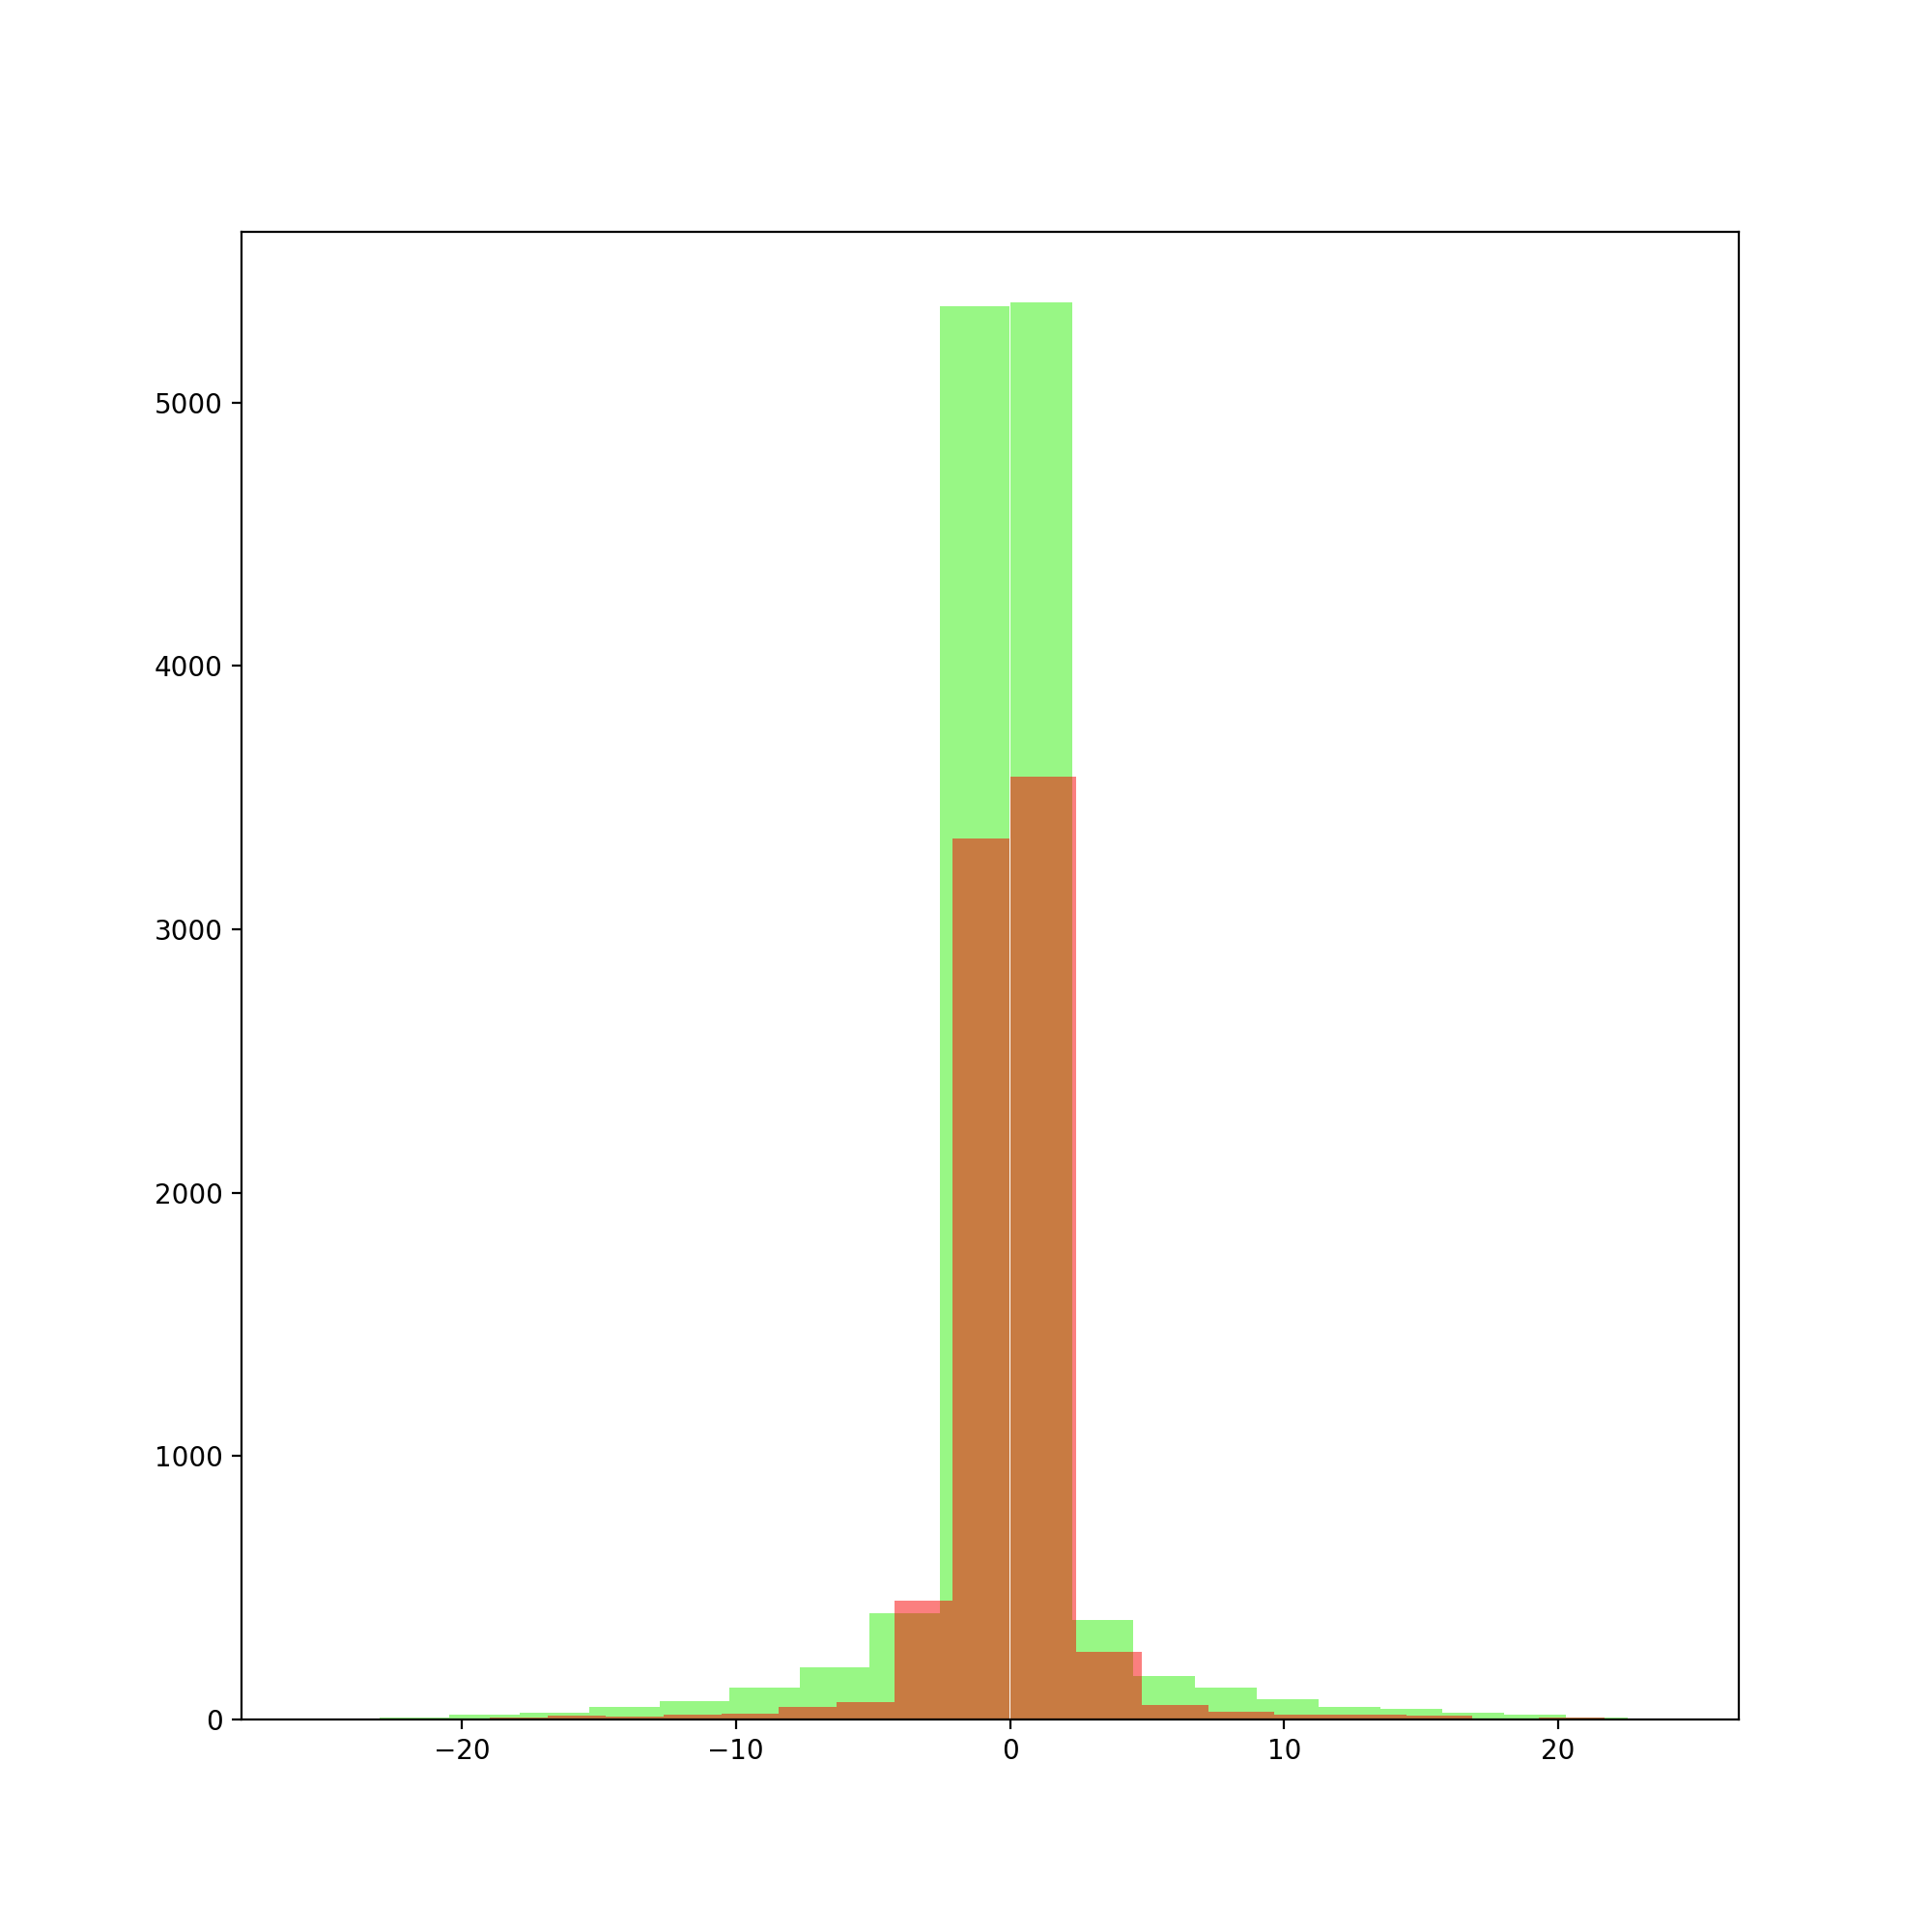

In [68]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(-1*BF_df['speed_left_std'], alpha=0.5, color='#33f10d')
ax.hist(BF_df['speed_right_std'], alpha=0.5, color='#33f10d')
ax.hist(-1*FL_df['speed_left_std'], alpha=0.5, color='#f90000')
ax.hist(FL_df['speed_right_std'], alpha=0.5, color='#f90000')


plt.show()

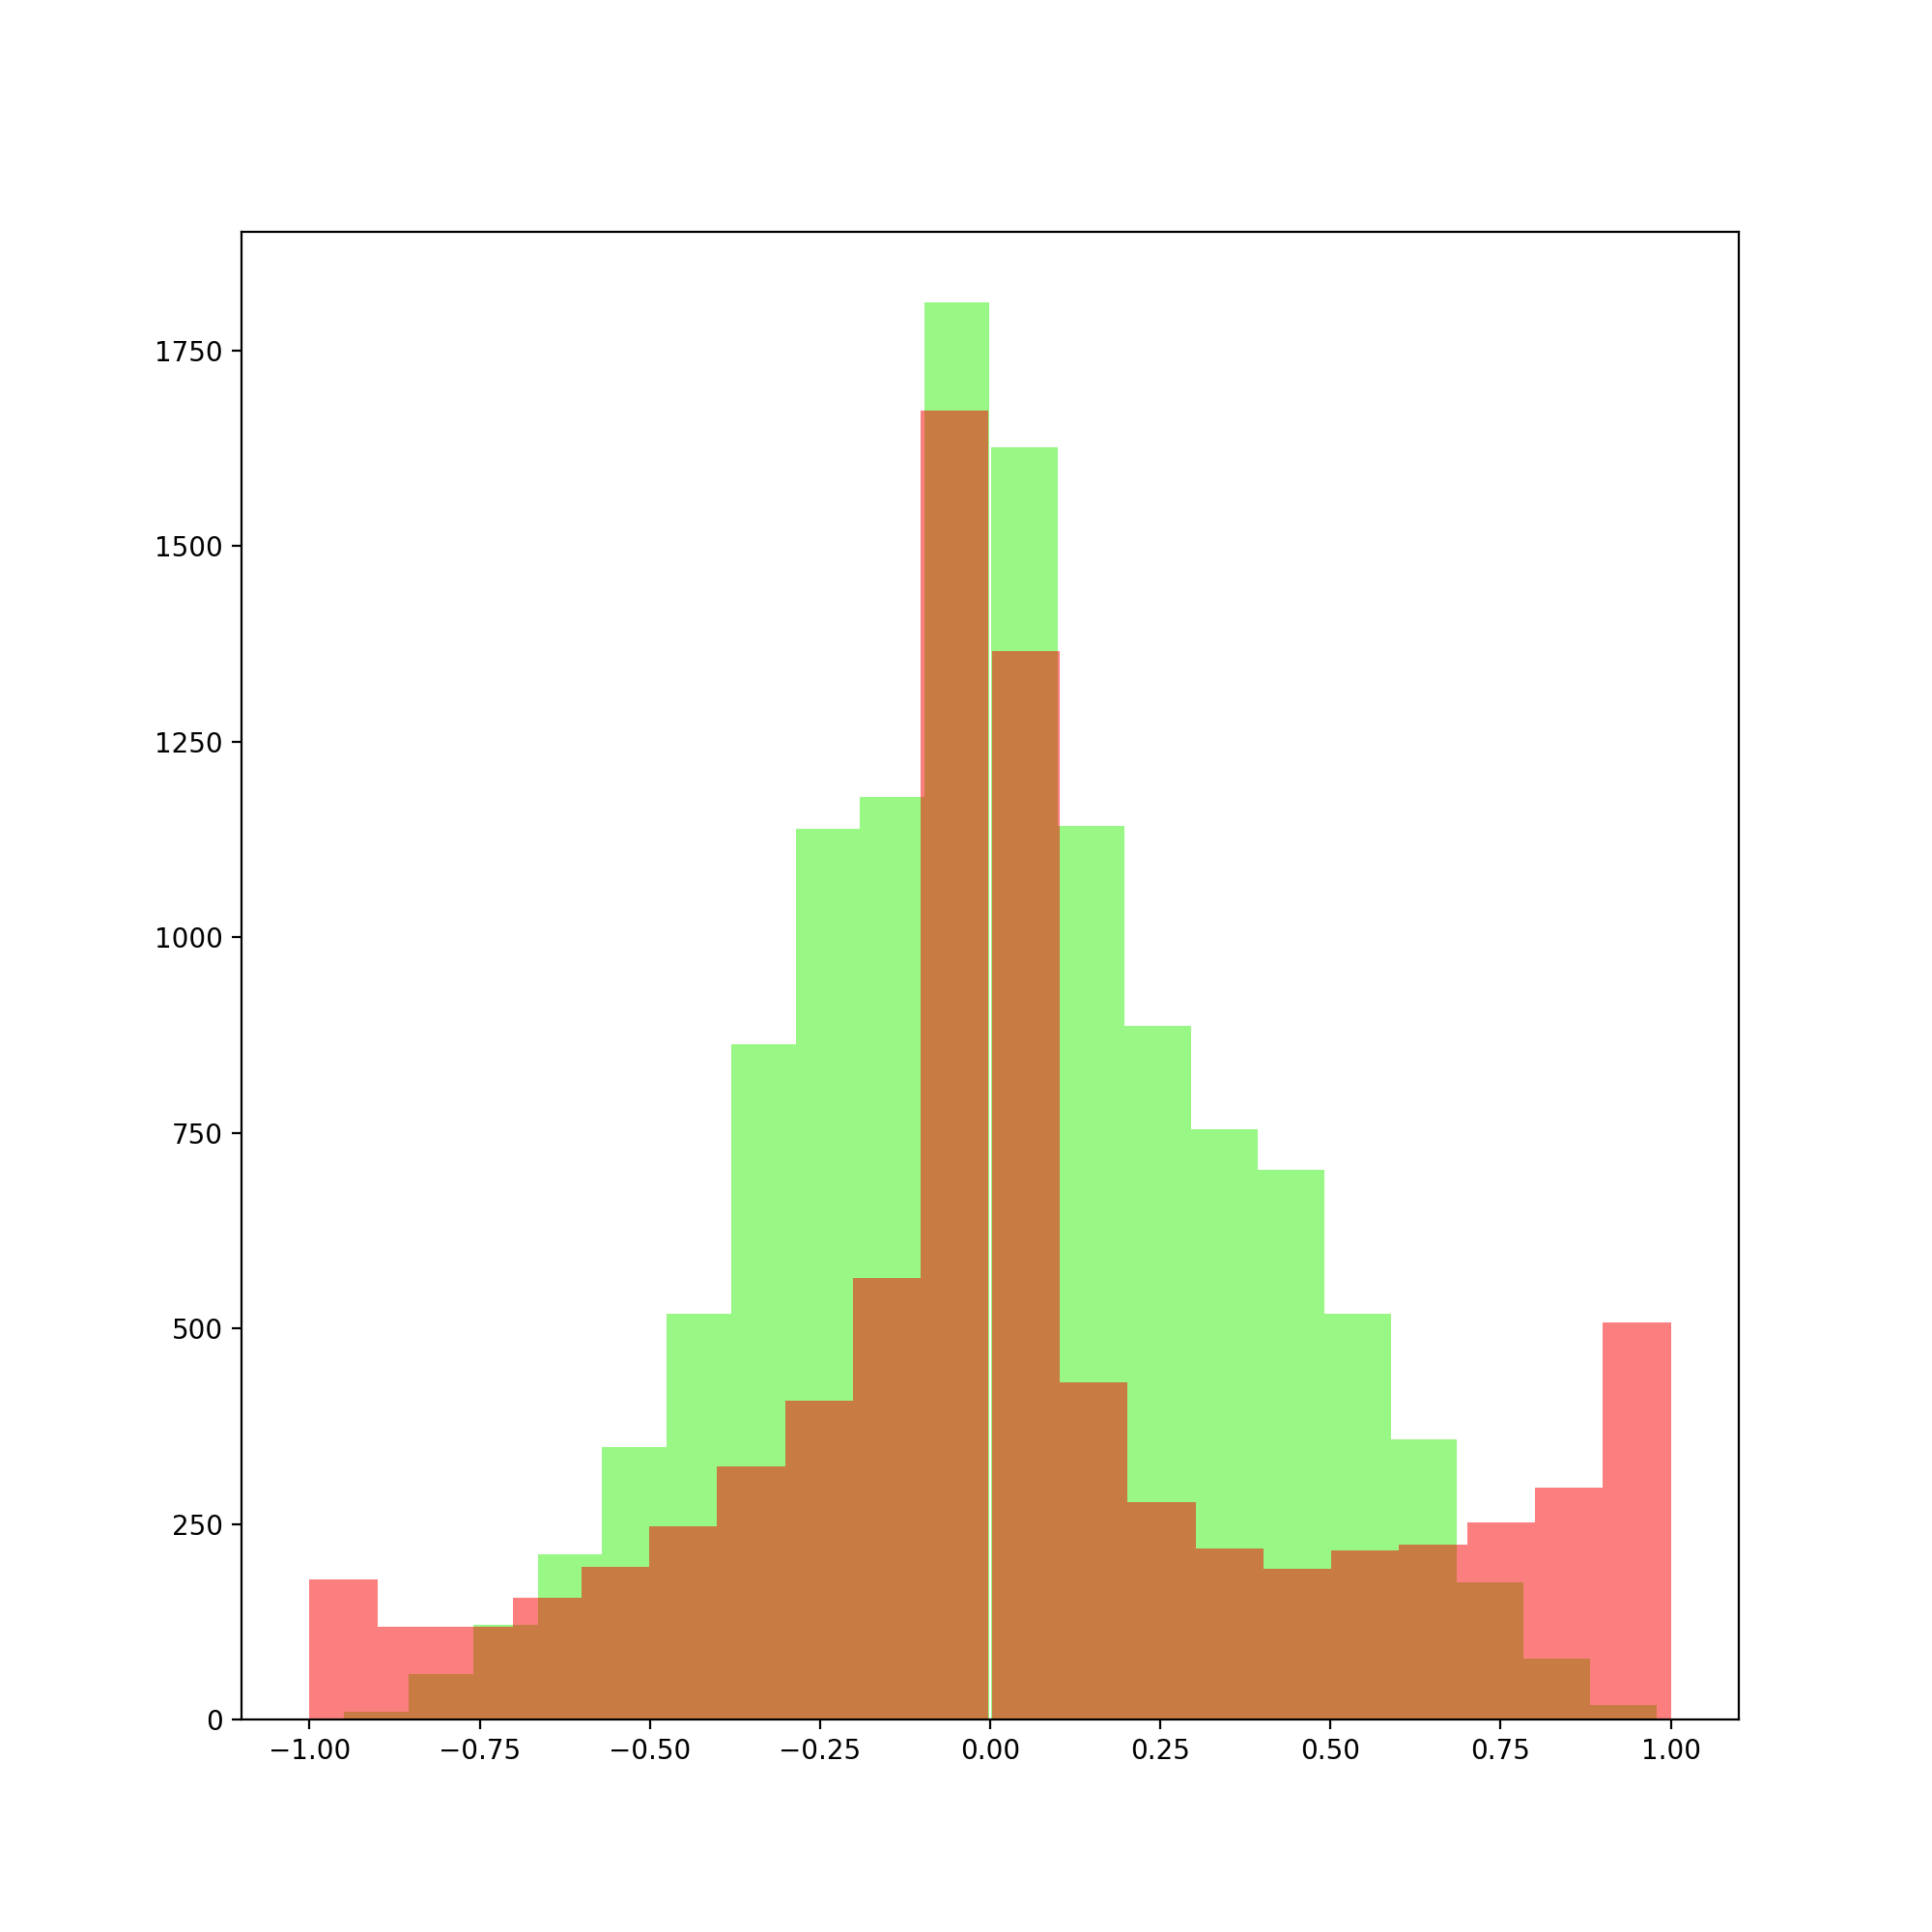

In [70]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(-1*BF_df['coverage_left'], alpha=0.5, color='#33f10d')
ax.hist(BF_df['coverage_right'], alpha=0.5, color='#33f10d')
ax.hist(-1*FL_df['coverage_left'], alpha=0.5, color='#f90000')
ax.hist(FL_df['coverage_right'], alpha=0.5, color='#f90000')


plt.show()

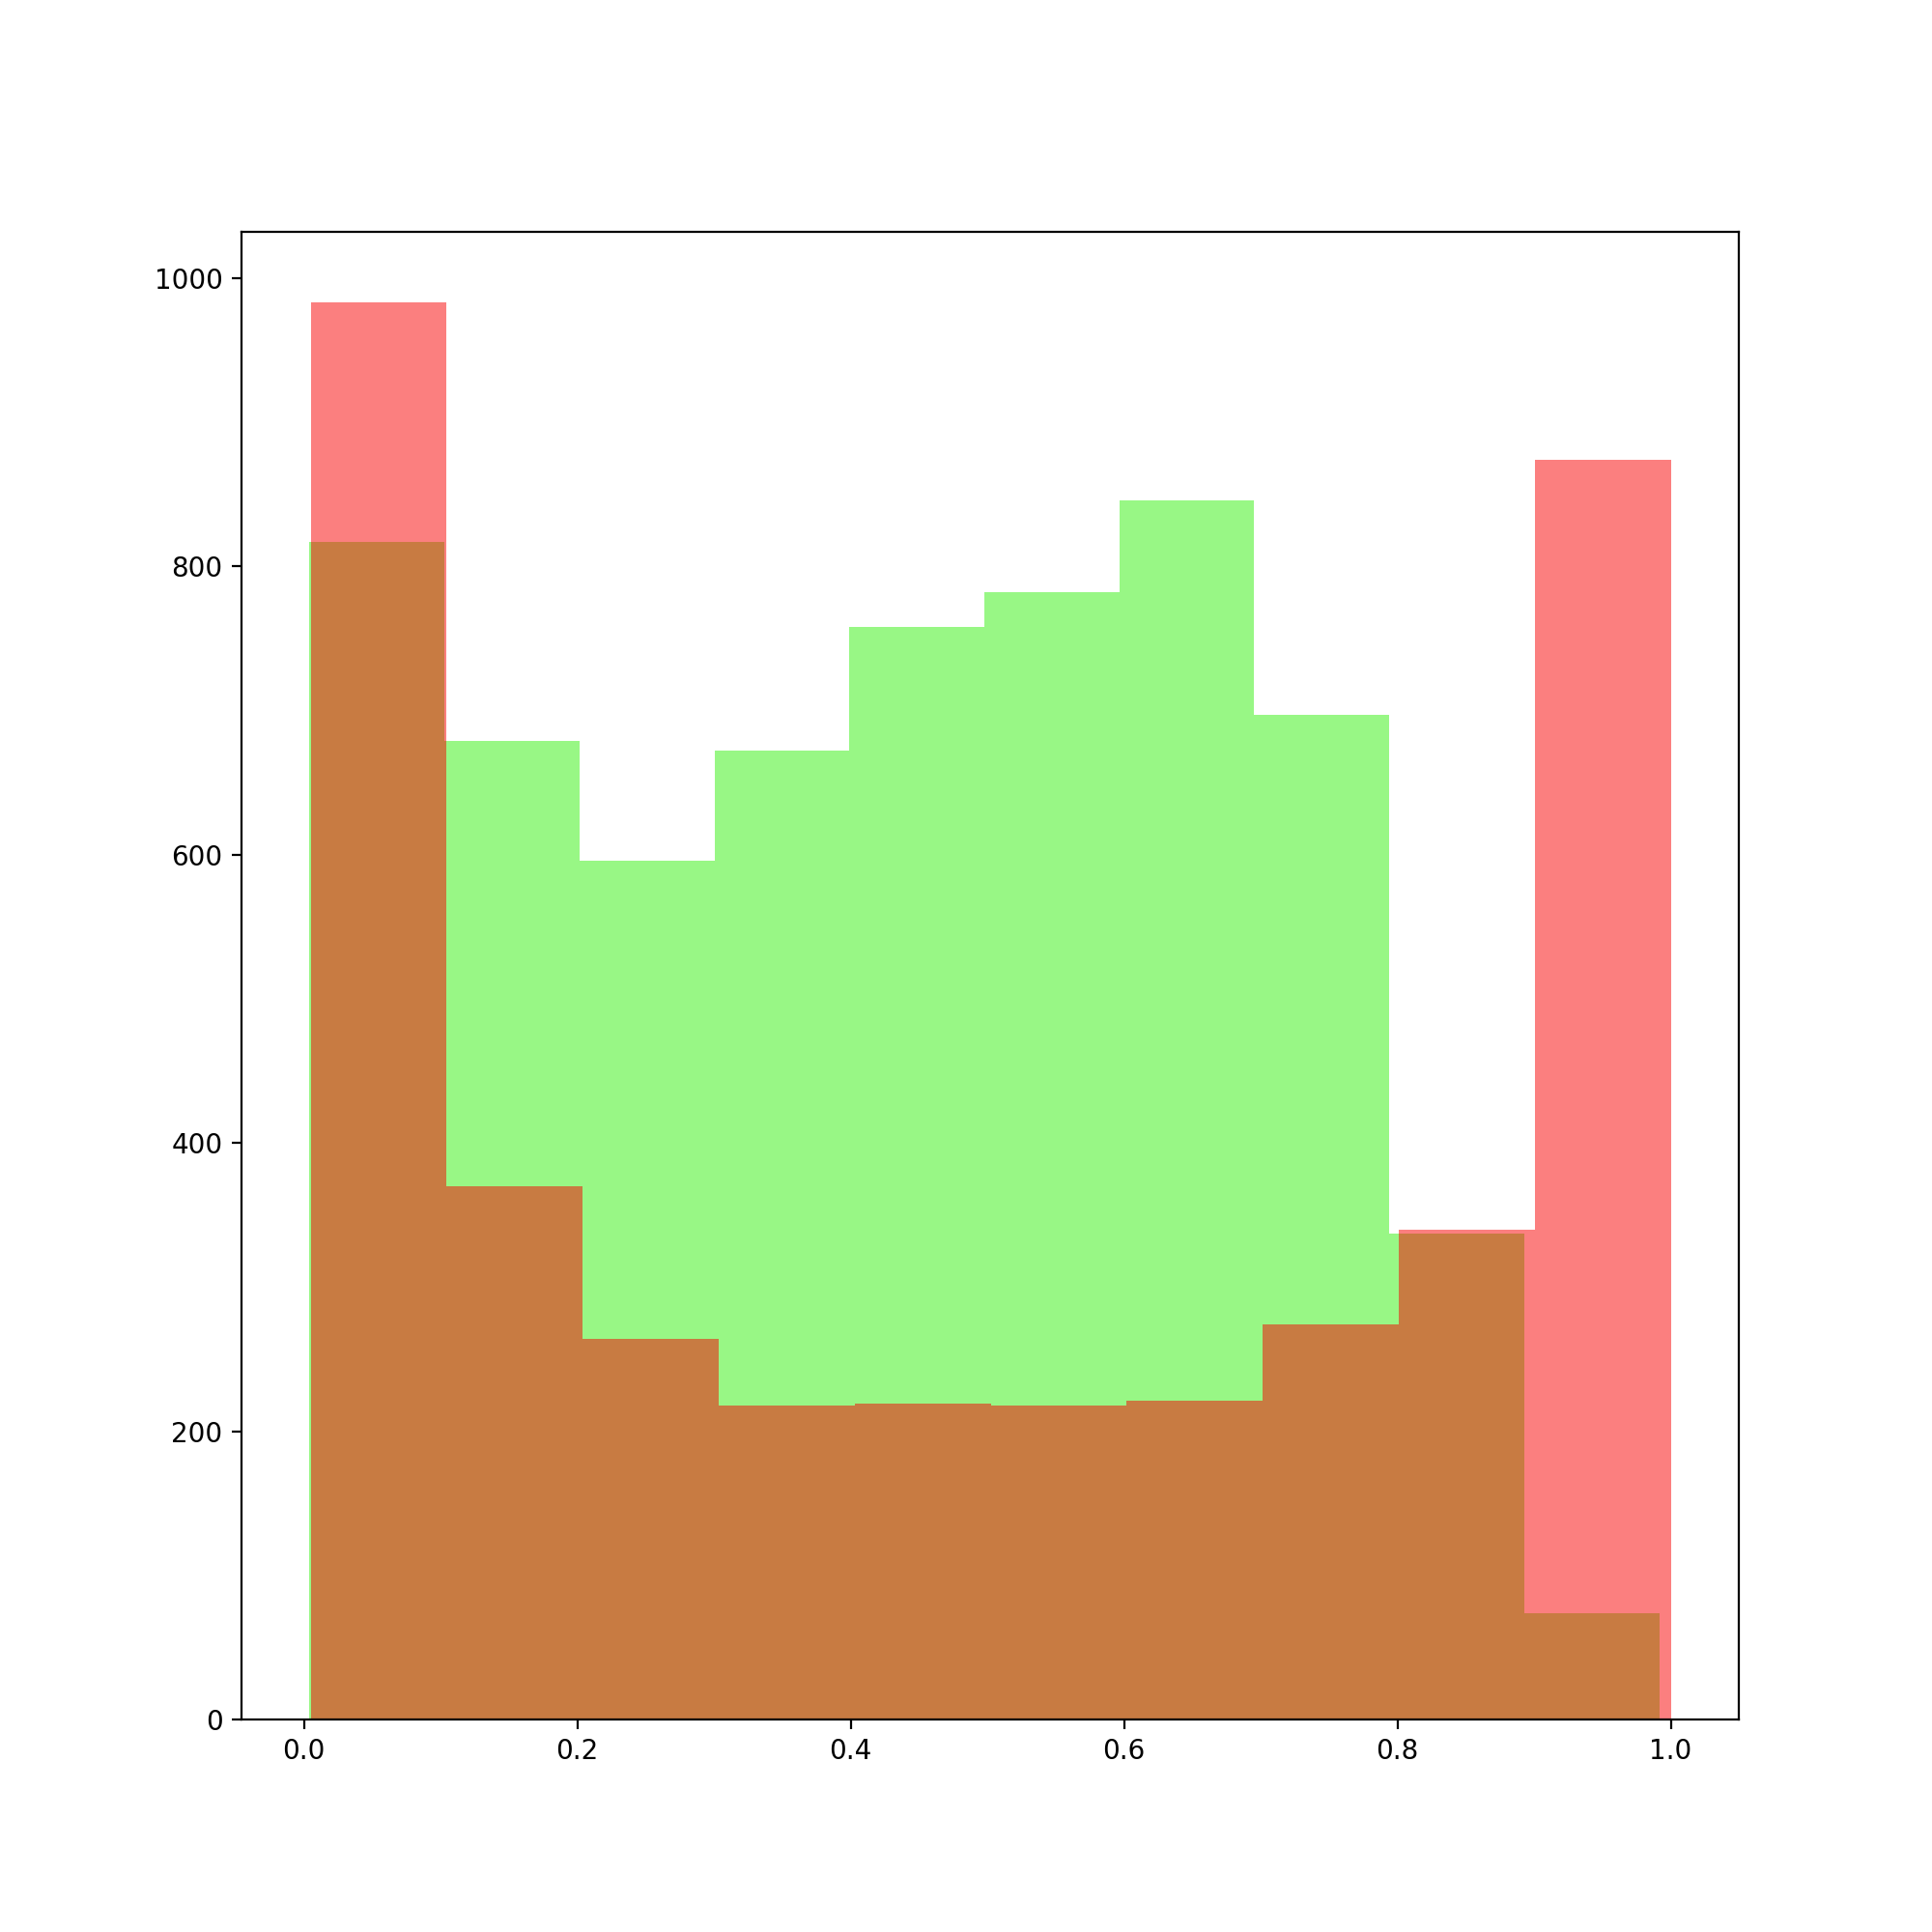

In [69]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(BF_df['coverage_tot'], alpha=0.5, color='#33f10d')
# ax.hist(BF_df['coverage_right'], alpha=0.5, color='#33f10d')
ax.hist(FL_df['coverage_tot'], alpha=0.5, color='#f90000')
# ax.hist(FL_df['coverage_right'], alpha=0.5, color='#f90000')


plt.show()

In [ ]:
import seaborn as sns
df = sns.load_dataset("penguins")
sns.pairplot(df, hue="species")

Save the data into a csv and upload to dropbox

In [7]:
combined_df.to_csv(analysis_folder+'Auto_Data.csv')


In [8]:
upload(analysis_folder+'Auto_Data.csv',dropbox_address+'Auto_Data.csv')

2024-02-02 15:05:09,054-[INFO]- dropbox:390 -> Refreshing access token.
2024-02-02 15:05:09,272-[INFO]- dropbox:474 -> Request to files/upload
